In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

Loading a smaller MNIST dataset, only with 3s and 7s:

In [3]:
path = untar_data(url = URLs.MNIST_SAMPLE, dest = '.')

Now let's look at one of the images:

In [4]:
threes = (path/'train'/'3').ls().sorted()
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Converting an image to a Pytorch tensor works like this:

In [5]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

Cool trick in Pandas that does gradient background for dataframes:

In [6]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


We first try a baseline model that classifies based on average pixel similarity:

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]


For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a rank-3 tensor. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called stack that we can use for this purpose.

In [8]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])


Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

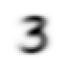

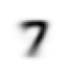

In [9]:
mean3 = stacked_threes.mean(0)
show_image(mean3)
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Let's create tensors for our 3s and 7s from the validation sets directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

In [10]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

We can write a simple function that calculates the mean absolute error:

In [11]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

We can use mnist_distance to figure out whether an image is a 3 or not by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

In [12]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

Pick a specific example:    

tensor(0.1114)

tensor(0.1586)

tensor(True)

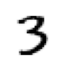

In [13]:
a_3 = stacked_threes[1]
show_image(a_3);
display(mnist_distance(a_3, mean3))
display(mnist_distance(a_3, mean7))
display(is_3(a_3))

Now we can calculate the accuracy of this baseline for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:

In [14]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## How SGD works in Pytorch:
We want to find the params of f(t) that fit the funnction speed the best.

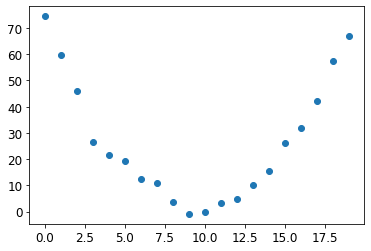

In [15]:
time = torch.arange(0,20).float(); time
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);


In [16]:

def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

def mse(preds, targets):
    return ((preds-targets)**2).mean().sqrt()

def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

lr = 1e-3

In [17]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [18]:
params = torch.randn(3).requires_grad_()
orig_params = params.clone()
for i in range(10): apply_step(params)

160.6978759765625
133.26524353027344
106.2302474975586
79.95720672607422
55.385318756103516
35.366943359375
26.461618423461914
26.02068519592285
26.01849937438965
26.018320083618164


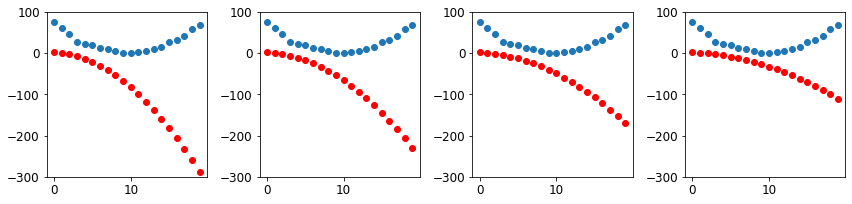

In [19]:
params = orig_params.detach().requires_grad_()
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: 
    show_preds(apply_step(params, False), ax)
plt.tight_layout()

## MNIST with SGD

We already have our independent variables x—these are the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). 

In [20]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We need a label for each image. We'll use 1 for 3s and 0 for 7s:

In [21]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))


A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. Python provides a zip function which, when combined with list, provides a simple way to get this functionality:

In [22]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [23]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))


Now we need an (initially random) weight for every pixel:

In [24]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
bias = init_params(1)

In [25]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [26]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [27]:
def linear1(xb): return xb@weights + bias # @ is matrix mult
preds = linear1(train_x)

In [28]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [29]:
def calc_grad(xb, yb, model): 
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [30]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [31]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [32]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [33]:
validate_epoch(linear1)

0.4917

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

In [34]:
for i in range(20):
    train_epoch(model=linear1, lr=1, params=(weights,bias))
    print(validate_epoch(linear1), end=' ')

0.4927 0.4922 0.4927 0.4927 0.4927 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 

## Creating an Optimizer

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our linear1 function with PyTorch's nn.Linear module. A module is an object of a class that inherits from the PyTorch nn.Module class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

In [35]:
linear_model = nn.Linear(28*28,1)
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [36]:
class BasicOptim:
    def __init__(self,params,lr): 
        self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None
            
opt = BasicOptim(linear_model.parameters(), lr)

In [37]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [38]:
validate_epoch(linear_model)

0.5105

In [39]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')
train_model(linear_model, 20)

0.5351 0.5898 0.7184 0.8352 0.9022 0.9373 0.9512 0.9561 0.9617 0.9627 0.9642 0.9637 0.9627 0.9627 0.9637 0.9632 0.9627 0.9627 0.9627 0.9632 

fastai provides the SGD class which, by default, does the same thing as our BasicOptim:

In [40]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.5846 0.7592 0.8594 0.9073 0.9259 0.9352 0.9416 0.946 0.9494 0.9524 0.9529 0.9543 0.9558 0.9558 0.9558 0.9563 0.9568 0.9568 0.9573 0.9573 

fastai also provides Learner.fit, which we can use instead of train_model. To create a Learner we first need to create a DataLoaders, by passing in our training and validation DataLoaders:

In [41]:
dls = DataLoaders(dl, valid_dl)

To create a Learner without using an application (such as cnn_learner) we need to pass in all the elements that we've created in this chapter: the DataLoaders, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [42]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [43]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.484636,0.481670,0.585378,00:00
1,0.470789,0.461140,0.763003,00:00
2,0.454959,0.440943,0.882237,00:00
3,0.438036,0.421328,0.913150,00:00
4,0.420766,0.402497,0.931305,00:00
5,0.403671,0.384596,0.942100,00:00
6,0.387075,0.367711,0.946025,00:00
7,0.371167,0.351879,0.951423,00:00
8,0.356050,0.337097,0.954367,00:00
9,0.341769,0.323335,0.954858,00:00


## Adding a Nonlinearity
So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

In [45]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res


w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)


The key point about this is that w1 has 30 output activations (which means that w2 must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels.

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

In [46]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [48]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.349871,0.411001,0.504416,00:00
1,0.162054,0.244127,0.784102,00:00
2,0.087840,0.119631,0.910206,00:00
3,0.056357,0.079412,0.941119,00:00
4,0.041935,0.061577,0.956330,00:00
5,0.034702,0.051717,0.963690,00:00
6,0.030631,0.045575,0.964671,00:00
7,0.028036,0.041395,0.966143,00:00
8,0.026190,0.038362,0.968106,00:00
9,0.024770,0.036055,0.971050,00:00


 the training process is recorded in learn.recorder, with the table of output stored in the values attribute, so we can plot the accuracy over training as:

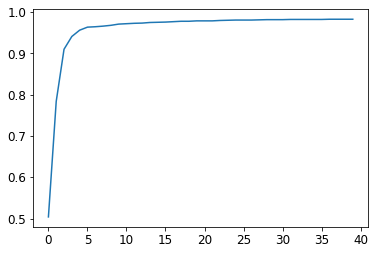

In [49]:

plt.plot(L(learn.recorder.values).itemgot(2));


There is no need to stop at just two linear layers. Here what happens when we train an 18-layer model using Resnet18:

In [52]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/home/szantamano/miniconda3/envs/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy,time
0,0.075491,0.013322,0.996565,00:37
